<a href="https://colab.research.google.com/github/ellencarols/Projeto-PIMG-ArUco/blob/main/detector_aruco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
#Aruco = ('Yes-Copy-2-_jpg.rf.eb555c7fd0819f2a20fc77389d4b24a0.jpg')
Aruco =

In [59]:
img = plt.imread(Aruco)

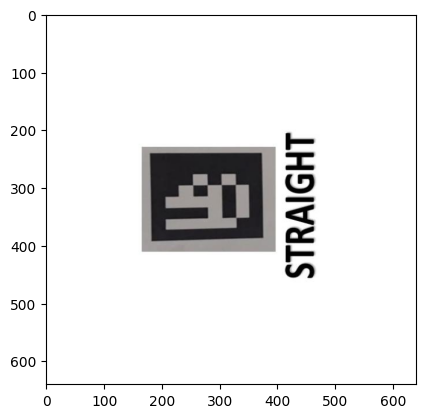

In [60]:
plt.imshow(img)

In [61]:
def rgb_para_cinza(img_rgb):
    """
    Converte uma imagem RGB para escala de cinza.
    """
    # Separação dos canais
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]

    # Conversão ponderada
    img_cinza = 0.299 * R + 0.587 * G + 0.114 * B

    return img_cinza.astype(np.uint8)

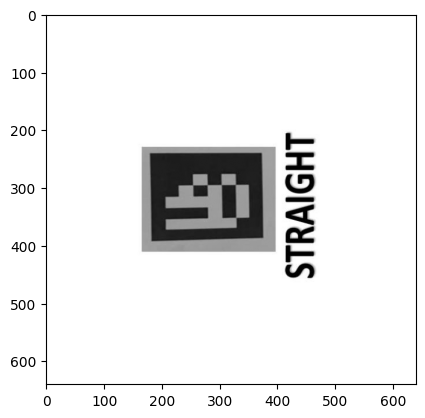

In [62]:
img_cinza = rgb_para_cinza(img)

plt.imshow(img_cinza, cmap="gray")
plt.show()


Filtragem Espacial

Filtro da mediana

In [63]:
def filtro_mediana(img, tamanho=3):
    """
    Aplica filtro da mediana em uma imagem em escala de cinza.
    for for = problema
    """
    altura, largura = img_cinza.shape
    offset = tamanho // 2

    img_filtrada = np.zeros_like(img_cinza)

    for i in range(offset, altura - offset):
        for j in range(offset, largura - offset):
            vizinhanca = img[
                i - offset : i + offset + 1,
                j - offset : j + offset + 1
            ]
            img_filtrada[i, j] = np.median(vizinhanca)

    return img_filtrada.astype(np.uint8)

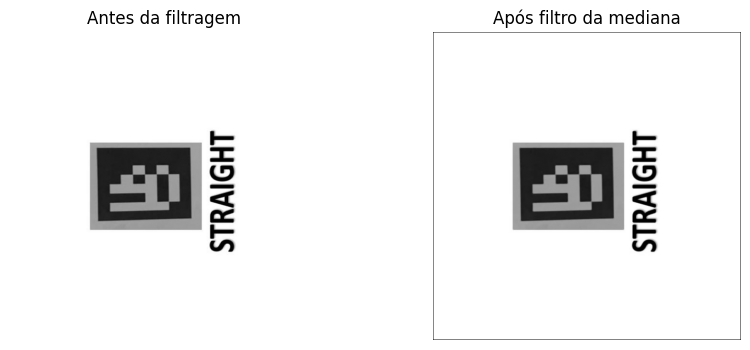

In [64]:
img_suave = filtro_mediana(img_cinza, tamanho=3)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img_cinza, cmap="gray")
plt.title("Antes da filtragem")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_suave, cmap="gray")
plt.title("Após filtro da mediana")
plt.axis("off")

plt.show()


binarização

In [65]:
def mostrar_histograma(imagem_gray):
    hist = np.zeros(256)

    for pixel in img_suave.flatten():
        hist[pixel] += 1

    plt.figure()
    plt.plot(hist)
    plt.xlabel("Nível de cinza")
    plt.ylabel("Número de pixels")
    plt.title("Histograma da imagem")
    plt.show()

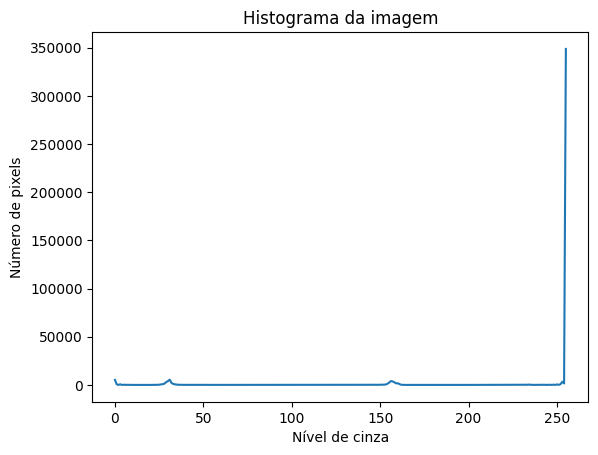

In [66]:
mostrar_histograma(img_suave)

Binarização

In [67]:
def binarizar(imagem_gray, T):
    binaria = np.zeros_like(img_suave)
    binaria[img_suave >= T] = 255
    return binaria

In [68]:
    T = 190
    imagem_bin = binarizar(img_suave, T)

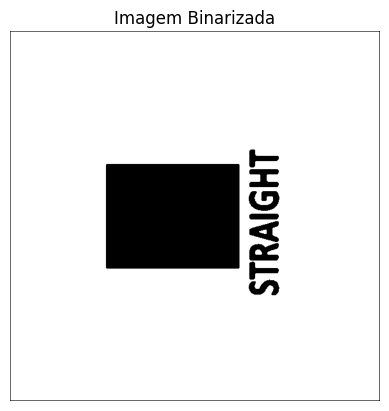

In [69]:
plt.imshow(imagem_bin, cmap='gray')
plt.title("Imagem Binarizada")
plt.axis('off')
plt.show()

Extração de bordas

In [70]:
def bordas_gradiente(imagem_bin):
    h, w = imagem_bin.shape
    # Cria uma matriz de zeros com o mesmo tamanho da original
    bordas = np.zeros_like(imagem_bin)

    # Loop para calcular o gradiente horizontal e vertical
    for i in range(h - 1):
        for j in range(w - 1):
            # Diferença entre pixels vizinhos (Gradiente)
            gx = abs(int(imagem_bin[i + 1, j]) - int(imagem_bin[i, j]))
            gy = abs(int(imagem_bin[i, j + 1]) - int(imagem_bin[i, j]))

            # Se houver variação, marcamos como borda (255)
            if gx + gy > 0:
                bordas[i, j] = 255

    return bordas

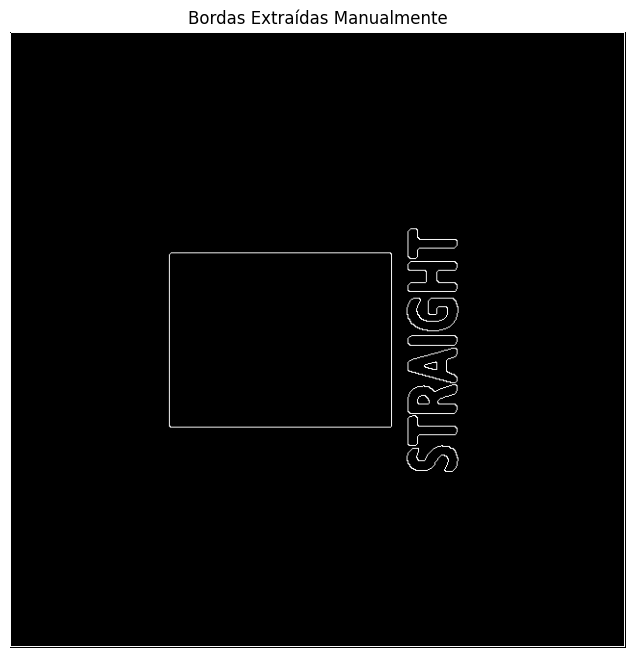

In [71]:
# Supondo que sua imagem binarizada se chama 'img_binaria'
# Chamamos a função e salvamos o resultado na variável 'bordas'
bordas = bordas_gradiente(imagem_bin)

# Agora exibimos o resultado
plt.figure(figsize=(8, 8))
plt.imshow(bordas, cmap='gray')
plt.title("Bordas Extraídas Manualmente")
plt.axis('off')
plt.show()

Transformada de Hough para detecção de retas

In [72]:
def transformada_hough_retas(bordas):
    altura, largura = bordas.shape
    diagonal = int(np.sqrt(altura**2 + largura**2))

    # Espaço de parâmetros
    valores_rho = np.arange(-diagonal, diagonal)
    valores_theta = np.deg2rad(np.arange(0, 180))

    acumulador = np.zeros((len(valores_rho), len(valores_theta)), dtype=np.int32)

    cos_theta = np.cos(valores_theta)
    sin_theta = np.sin(valores_theta)

    # Coordenadas dos pixels de borda
    ys, xs = np.where(bordas == 255)

    # Votação
    for x, y in zip(xs, ys):
        for idx_theta in range(len(valores_theta)):
            rho = int(x * cos_theta[idx_theta] + y * sin_theta[idx_theta])
            idx_rho = rho + diagonal
            acumulador[idx_rho, idx_theta] += 1

    return acumulador, valores_rho, valores_theta

In [73]:
acumulador, valores_rho, valores_theta = transformada_hough_retas(bordas)

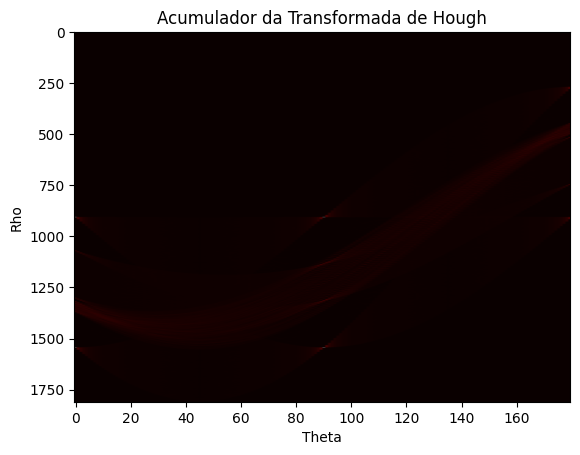

In [74]:
import matplotlib.pyplot as plt

plt.imshow(acumulador, cmap='hot', aspect='auto')
plt.title("Acumulador da Transformada de Hough")
plt.xlabel("Theta")
plt.ylabel("Rho")
plt.show()


Encontrar as retas (picos no acumulador)

In [75]:
def detectar_retas_hough(acumulador, valores_rho, valores_theta, limiar):
    retas = []

    num_rho, num_theta = acumulador.shape

    for i in range(num_rho):
        for j in range(num_theta):
            if acumulador[i, j] >= limiar:
                rho = valores_rho[i]
                theta = valores_theta[j]
                retas.append((rho, theta))

    return retas


In [76]:
limiar = 100  # pode ajustar depois
retas_detectadas = detectar_retas_hough(acumulador, valores_rho, valores_theta, limiar)

print(f"Número de retas detectadas: {len(retas_detectadas)}")


Número de retas detectadas: 9


Desenhar as retas

In [77]:
def desenhar_retas_hough(imagem_original, retas_detectadas):
    # Cria uma cópia da imagem original
    imagem_com_retas = imagem_original.copy()

    # Se a imagem estiver em tons de cinza, converte para RGB manualmente
    if len(imagem_com_retas.shape) == 2:
        imagem_com_retas = np.stack([imagem_com_retas]*3, axis=-1)

    h, w, _ = imagem_com_retas.shape

    for rho, theta in retas_detectadas:
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)

        for x in range(w):
            if abs(sin_t) > 1e-6:
                y = int((rho - x * cos_t) / sin_t)

                if 0 <= y < h:
                    # Marca o pixel da reta em vermelho
                    imagem_com_retas[y, x] = [255, 0, 0]

    return imagem_com_retas


In [78]:
imagem_com_retas = desenhar_retas_hough(img, retas_detectadas)


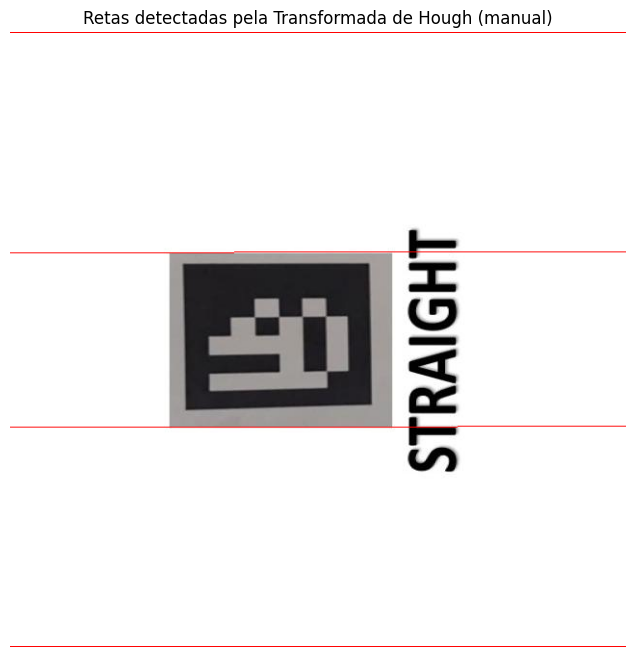

In [79]:
plt.figure(figsize=(8, 8))
plt.imshow(imagem_com_retas)
plt.title("Retas detectadas pela Transformada de Hough (manual)")
plt.axis('off')
plt.show()
